In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('../artifacts/sentiment_analysis.csv')
data.head() , data.shape

(   id  label                                              tweet
 0   1      0  #fingerprint #Pregnancy Test https://goo.gl/h1...
 1   2      0  Finally a transparant silicon case ^^ Thanks t...
 2   3      0  We love this! Would you go? #talk #makememorie...
 3   4      0  I'm wired I know I'm George I was made that wa...
 4   5      1  What amazing service! Apple won't even talk to...,
 (7920, 3))

### preprocessing

In [3]:
data.duplicated().sum(), data.isnull().sum()

(0,
 id       0
 label    0
 tweet    0
 dtype: int64)

In [4]:
ps = PorterStemmer()
lem = WordNetLemmatizer()
def data_cleaning(text):
    review = re.sub('[^a-zA-Z]',' ' ,text)
    review = re.sub(r'https?:\/\/.*[\r\n]*',' ',review, flags=re.MULTILINE)
    review = review.lower()
    review = review.split()
    review = [lem.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = " ".join(review)
    return review

In [5]:
data['clean_tweets']=data['tweet'].apply(data_cleaning)

In [6]:
X = data['clean_tweets']
y = data['label']

In [7]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf.fit_transform(X).toarray()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [9]:
y_train.value_counts().values,y_train.value_counts().index


(array([4132, 1412], dtype=int64), Index([0, 1], dtype='int64', name='label'))

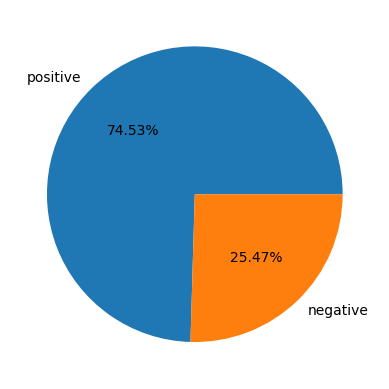

In [10]:
plt.pie(x=y_train.value_counts().values, labels=['positive' if i==0 else 'negative' for i in y_train.value_counts().index], autopct='%1.2f%%')
plt.show()

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

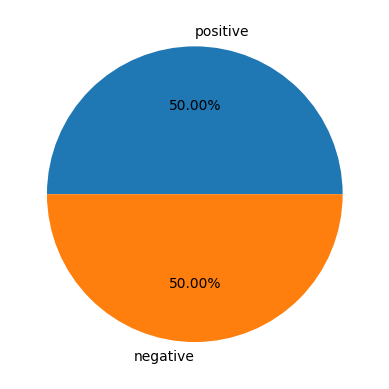

In [12]:
plt.pie(x=y_train_smote.value_counts().values, labels=['positive' if i==0 else 'negative' for i in y_train_smote.value_counts().index], autopct='%1.2f%%')
plt.show()

In [13]:
def model_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    pr = precision_score(y_pred, y_test)
    rec = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    print(f"accuracy: {acc}\nprecision: {pr}\nrecall: {rec}\nf1-score: {f1}")

In [14]:
params_nb = {
    'alpha': 0.89,
    'fit_prior': False,
}

model_nb = MultinomialNB(**params_nb)


model_nb.fit(X_train_smote,y_train_smote)

MultinomialNB(alpha=0.89, fit_prior=False)

In [15]:
model_predictions(model_nb, X_test, y_test)

accuracy: 0.8775252525252525
precision: 0.9446254071661238
recall: 0.6929510155316607
f1-score: 0.7994486560992419


In [16]:
lgb_params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'learning_rate': 0.01,
    'num_leaves': 60,
    'random_state':42,
    'objective':'binary',
    'boosting_type': 'gbdt',
    'feature_fraction':0.9,
    'metric': 'binary_logloss',
    'sub_sample': 0.8,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5
}
model_lgb = lgb.LGBMClassifier(**lgb_params)

model_lgb.fit(X_train_smote, y_train_smote)

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Number of positive: 4132, number of negative: 4132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

LGBMClassifier(feature_fraction=0.9, lambda_l1=0.5, lambda_l2=0.5,
               learning_rate=0.01, max_depth=10, metric='binary_logloss',
               n_estimators=1000, num_leaves=60, objective='binary',
               random_state=42, sub_sample=0.8)

In [17]:
model_predictions(model_lgb, X_test, y_test)

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
accuracy: 0.8867845117845118
precision: 0.9022801302931596
recall: 0.7260812581913499
f1-score: 0.8046477850399419


In [18]:
model_lr = LogisticRegression()
model_lr.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [19]:
model_predictions(model_lr, X_test, y_test)

accuracy: 0.8960437710437711
precision: 0.9055374592833876
recall: 0.7463087248322148
f1-score: 0.8182487122884474


In [20]:
model_svm = SVC(random_state=0)
model_svm.fit(X_train_smote , y_train_smote)

SVC(random_state=0)

In [21]:
model_predictions(model_svm, X_test, y_test)

accuracy: 0.9023569023569024
precision: 0.8355048859934854
recall: 0.796583850931677
f1-score: 0.8155802861685215


In [22]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [23]:
model_predictions(model_rf, X_test, y_test)

accuracy: 0.88510101010101
precision: 0.8583061889250815
recall: 0.7391304347826086
f1-score: 0.7942727957799548


In [24]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [25]:
model_predictions(model_dt, X_test, y_test)

accuracy: 0.8404882154882155
precision: 0.7296416938110749
recall: 0.6777609682299546
f1-score: 0.7027450980392157


In [28]:
import pickle

with open('../static/model/model.pickle', 'wb') as file:
    pickle.dump(model_lr, file)

In [29]:
with open('../static/model/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf, f)
